In order to know what is *decision tree regressor* we start by looking at an example of predicting baseball players' salary in function of `Years` and `Hist`

First we load some modules

In [10]:
import numpy as np
import time, sys

# add parent to search path
if '..' not in sys.path:
    sys.path.insert(0, '..')

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

# imported helpers function   
from helpers import data_utils, vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's download the dataset `Hitters` and visualize it

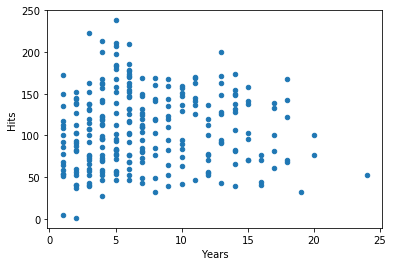

In [2]:
data = data_utils.load_hitters()

# filte na while selecting only 'Years', 'Hits', 'Salary'
data = data[['Years', 'Hits', 'Salary']].dropna(axis = 0) 

# visualize it
_ = data.plot.scatter(x = 'Years', y = 'Hits')

features = data[['Years', 'Hits']].values
targets = data['Salary'].values

Let segment above feature spaces into 3 regions

$$
\begin{split}
R_1 &= \left\{X\ |\ \texttt{Years} < 4.5\right\}\\
R_2 &= \left\{X\ |\ \texttt{Years} \geq 4.5, \texttt{Hits} < 117.5\right\}\\
R_2 &= \left\{X\ |\ \texttt{Years} \geq 4.5, \texttt{Hits} \geq 117.5\right\}
\end{split}
$$

The segmentation is illustrated below

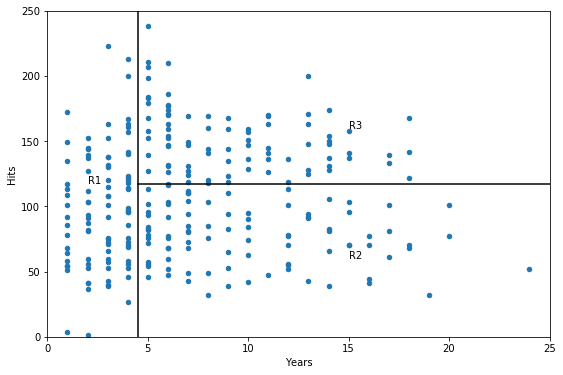

In [3]:
ax = data.plot.scatter(x = 'Years', y = 'Hits')
ax.figure.set_figheight(6)
ax.figure.set_figwidth(9)
ax.set_xlim([0, 25])
ax.set_ylim([0, 250])
_ = ax.plot([4.5,4.5], [0, 250], c = 'black')
_ = ax.plot([4.5,25], [117.5, 117.5], c = 'black')
_ = ax.text(2, 117.5, 'R1')
_ = ax.text(15, 60, 'R2')
_ = ax.text(15, 160, 'R3')

Then the predicted salary is given by the **mean** salary for the players in each region i.e if a player with `Years<4.5`, then his salary is estimated by the **mean** salary of $R_1$. Roughly speaking, building decision tree regression needs two steps

1. We divide the feature space - into $K$ distinct and non-overlapping regions $R_1,R_2,\ldots,R_K$
2. For each observation that falls into the region $R_j$, we make the same prediction, which is simply the mean of the target values for the training observations in $R_j$

## Regression Tree

As any supervised algorithm, we start by defining the loss function. Here we will use the residual sum of square (**RSS**) is define as

$$
\begin{split}
J(R_1,\ldots,R_K) &= \sum_{j=1}^{K}\sum_{i\in R_j}\left(y^{(i)} - \hat{y}_{R_j}\right)^2\\
\hat{y}_{R_j} &= \mathbb{E}_{i\in R_j}[y^{(i)}]
\end{split}
$$

In theory $R_j$ can be any shape but it's computationally infeasible to consider every possible partition. For this reason, we take a *top-down, greedy* approach that is known as *recursive binary splitting*:
* it begins at the top the tree (at which point all observations belong to a single region) 
* and then successively splits the feature space: 
    * each split is made at a particular feature which creates two new branches further down
    * the feature for a split is choosen in greedy manner (the feature that reduce the **RSS** the most at current step)

Assumed we have $D$ features $x^{(i)}\in\mathbb{R}^D$, the first step is to find

$$
j,s = \mathrm{arg}\min_{j,s}\left[\sum_{i:x^{(i)}_j < s}\left(y^{(i)} - y^{left}\right)^2 + \sum_{i:x^{(i)}_j \geq s}\left(y^{(i)} - y^{right}\right)^2\right]
$$

where 

$$
\begin{split}
y^{left} &= \frac{\sum_{i:x^{(i)}_j < s}y^{(i)}}{\# \left\{ i:x^{(i)}_j < s\right\}}\\
y^{right} &= \frac{\sum_{i:x^{(i)}_j < s}y^{(i)}}{\# \left\{ i:x^{(i)}_j \geq s\right\}}
\end{split}
$$

Having found the best first split, we repeat the splitting process in each of the two regions. Then this process is repeated on all of the resulting regions.

### Implementation

We will implement the *recursive binary splitting* algorithm (it might not be as efficient as one implemented in `sklearn`)

First we implement a function to compute *bestSplit*

In [4]:
def sortedIdx(features):
    '''
    Compute a sorted indices for each columns
    
    Input:
        features is 2d arrays
    Return 
        idx of same size as features such that
            features[idx[:,i],i] is increasing
    '''    
    return np.argsort(features, axis=0)
    
def bestSplit(features, targets, num_min_node = 2):
    N,D = features.shape
    
    if N < 2*num_min_node:
        return
    
    idx = sortedIdx(features)
    
    target_mean = np.mean(targets)
    target_sum = np.sum(targets)
    best_val = N * np.square(target_mean)
    best_idx = None
    best_j   = None
    best_level = None
    
    step = 0
    for i in range(D):
        xi = features[idx[0,i], i]
        sum_left = targets[idx[0,i]]
        
        for j in range(1, N-1):
            xi_next = features[idx[j,i], i] 
            
            if xi_next > xi:
                # do a cut between xi & xi_next
                y_left  = sum_left / j
                y_right = (target_sum - sum_left) / (N - j)
                
                # check if it's better
                new_val = j * np.square(y_left) + (N-j) * np.square(y_right)
                
                if new_val > best_val:
                    best_val = new_val
                    best_idx = i
                    best_j   = j
                    best_level = (xi + xi_next) / 2
                
                # update xi
                xi = xi_next
            
            sum_left += targets[idx[j,i]]
    
    left, right = None, None
    if (best_idx is not None):
        left  = idx[:best_j, best_idx]
        right = idx[best_j:, best_idx]
    return best_idx, best_level, left, right

Try the best split on input data, we found the best split for the first two steps

In [42]:
# step 0
best_idx, best_level, left, right = bestSplit(features, targets)
print (best_idx, best_level)

# step 1
best_idx, best_level, right_left, right_right = bestSplit(features[right], targets[right])
print (best_idx, best_level)

best_idx, best_level, left_left, left_right = bestSplit(features[left], targets[left])
print (best_idx, best_level)


0 4.5
1 117.5
1 2.5


The above implementation illustrates how we manually split a node. In practice, we need a scheme to automatically doing the split. In this notebook, we look at one of these schemes: `Best-First-Search` which involves the following iterative steps

* each time we compute a node-split we push the node-split + loss-improvement into a `Priority-Max-Heap pmh`
* while `pmh` is not empty, we extract it and compute node-split on the left-child and right-child then push these node-split into `pmh`

The iterative steps end when we reach max-depth of minimum samples per leaf/split. This process is implemented in these files

* `tree_loss.py`: compute RSS loss for current node, left node and right node
* `tree_splitter.py`: compute node-split
* `tree.py`: building the tree for regression or classification

### Test our implementation

Let's test our implementation on our `Hitters` dataset

In [51]:
from helpers.tree import RegressorTree

clf = RegressorTree(2)
clf.fit(features, targets)

In [52]:
for n in clf._nodes:
    print (n)

(0, 4.500000) left[None] right[None]
(1, 2.500000) left[None] right[None]
(1, 117.500000) left[None] right[None]


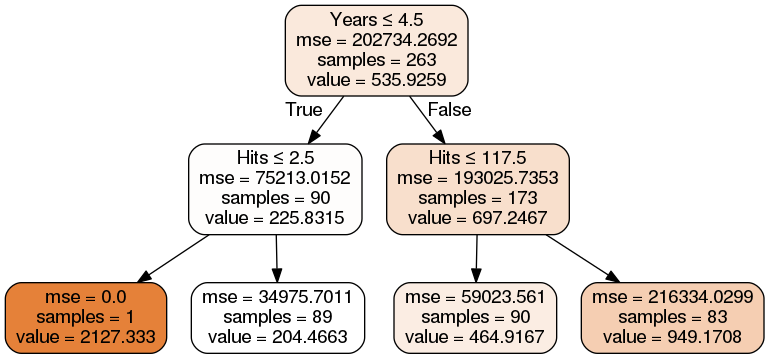

In [53]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

dtr = DecisionTreeRegressor(max_depth = 2)

dtr.fit(features, targets)
print(dtr.tree_)

from IPython.display import Image  
import pydotplus
dot_data = export_graphviz(dtr, out_file=None, 
                           feature_names=['Years', 'Hits'],  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())